<a href="https://colab.research.google.com/github/Dhanush-adk/machine_learning/blob/main/assignment_6/assignment_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Use the URL for the raw CSV data
url = 'https://raw.githubusercontent.com/Dhanush-adk/machine_learning/main/assignment_2/Housing.csv#'
df = pd.read_csv(url)

# Display the first 5 rows of the DataFrame
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
df['furnishingstatus'].value_counts().unique
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=False)
df = df.drop('furnishingstatus_semi-furnished', axis=1)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,1,0
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,1,0
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,0,0
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,1,0
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,1,0


In [5]:
binary_columns = df.select_dtypes(include=['object']).columns
binary_columns

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')

In [6]:
df[binary_columns] = df[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [7]:
df.shape

(545, 14)

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [10]:
X = df.drop('price', axis = 1)
y = df[['price']]

In [11]:
X = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns, index=X.index).values
y = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index).values

In [12]:
train_X, val_X, train_Y, val_Y = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(train_X)
y_train =  torch.tensor(train_Y)
X_val =  torch.tensor(val_X)
y_val =  torch.tensor(val_Y)

In [13]:
training_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [14]:
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=32)

In [15]:
def model_train(model, criterion, optimizer, epochs, train_loader, X_val, y_val):
    loss_train = []
    loss_val = []
    for epoch in range(epochs + 1):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            if epoch % 500 == 0:
              print(f'Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
              loss_val.append(val_loss)
              loss_train.append(loss)
    return loss_train, loss_val

#Problem 1.A

In [16]:
# Model 1
model1 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 1)
).to(torch.float64)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
train_loss, val_loss = model_train(model1, nn.MSELoss(), optimizer1, 5000, train_loader, X_val, y_val)

Epoch 0/5000, Training Loss: 0.13479321421621576, Validation Loss: 0.12944924162562316
Epoch 500/5000, Training Loss: 0.005263849907608023, Validation Loss: 0.013350897684769731
Epoch 1000/5000, Training Loss: 0.005440372397095665, Validation Loss: 0.013387048875585263
Epoch 1500/5000, Training Loss: 0.010573655048116987, Validation Loss: 0.013285255660351042
Epoch 2000/5000, Training Loss: 0.014485567963921706, Validation Loss: 0.013196684366835265
Epoch 2500/5000, Training Loss: 0.009253059556540516, Validation Loss: 0.0132424495580042
Epoch 3000/5000, Training Loss: 0.005362221820670607, Validation Loss: 0.013119574122906978
Epoch 3500/5000, Training Loss: 0.004463070046569513, Validation Loss: 0.013153756345785712
Epoch 4000/5000, Training Loss: 0.005792864793924615, Validation Loss: 0.013140596755189084
Epoch 4500/5000, Training Loss: 0.006029034425012379, Validation Loss: 0.013057903291848064
Epoch 5000/5000, Training Loss: 0.004728113629085707, Validation Loss: 0.013016197663128

In [17]:
for name, param in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [18]:
total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  481 



In [19]:
epochs = range(0, 5001, 500)
epochs

range(0, 5001, 500)

<ipython-input-20-35ce0b57a771>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


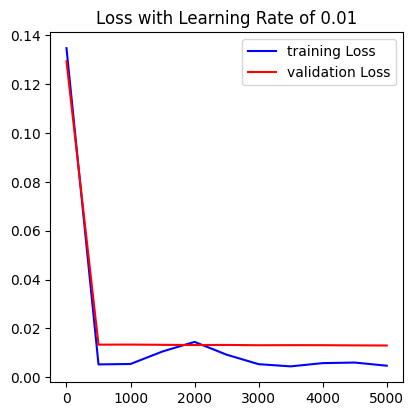

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss]), color='blue', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss]), color='red', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.01')
plt.legend()

plt.show()

#Problem 1.b

In [25]:
model2 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 64),  # Second hidden layer with 64 neurons
    nn.Tanh(),
    nn.Linear(64, 16),  # Third hidden layer with 16 neurons
    nn.Tanh(),
    nn.Linear(16, 1) # Output layer with 1 neuron
).to(torch.float64)
criterion = nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
train_loss_2, val_loss_2 = model_train(model2, nn.MSELoss(), optimizer2, 5000, train_loader, X_val, y_val)

Epoch 0/5000, Training Loss: 0.08788985850405731, Validation Loss: 0.08561909055247982
Epoch 500/5000, Training Loss: 0.007374374628420324, Validation Loss: 0.01338775126824809
Epoch 1000/5000, Training Loss: 0.014008368608617996, Validation Loss: 0.013318145187544848
Epoch 1500/5000, Training Loss: 0.005482545329039276, Validation Loss: 0.013369813144969682
Epoch 2000/5000, Training Loss: 0.011436628537764799, Validation Loss: 0.01329485355947755
Epoch 2500/5000, Training Loss: 0.004584758458508103, Validation Loss: 0.013404868274727467
Epoch 3000/5000, Training Loss: 0.004634937517005335, Validation Loss: 0.01335382142859115
Epoch 3500/5000, Training Loss: 0.006261820953054989, Validation Loss: 0.013191408056452877
Epoch 4000/5000, Training Loss: 0.010561282787408397, Validation Loss: 0.013315142453064274
Epoch 4500/5000, Training Loss: 0.0045049691154895235, Validation Loss: 0.013301048357267226
Epoch 5000/5000, Training Loss: 0.005782862265507907, Validation Loss: 0.013126145697619

In [26]:
for name, param in model2.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([64, 32])
Parameter name: 2.bias, Shape: torch.Size([64])
Parameter name: 4.weight, Shape: torch.Size([16, 64])
Parameter name: 4.bias, Shape: torch.Size([16])
Parameter name: 6.weight, Shape: torch.Size([1, 16])
Parameter name: 6.bias, Shape: torch.Size([1])


In [27]:
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  3617 



<ipython-input-28-c0e00fb50043>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


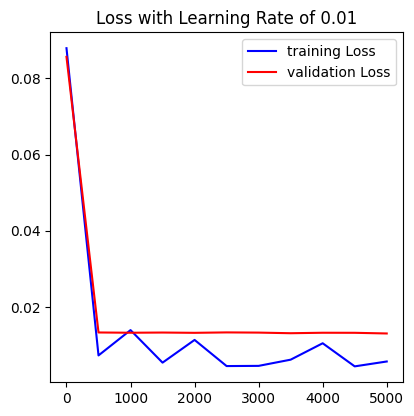

In [28]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss_2]), color='blue', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss_2]), color='red', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.01')
plt.legend()

plt.show()
